# Import des librairies

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Import dataset

In [16]:
link = '/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/df_final_15min_NoNan_20250505.parquet'

In [17]:
df_trafic = pd.read_parquet(link)

In [18]:
df_prediction_taux_occupation = pd.read_csv('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/donnees_predictions/taux_occupation_predictions.csv')

# Preprocessing

In [19]:
df_prediction_taux_occupation['heure_arrondie'] = pd.to_datetime(df_prediction_taux_occupation['heure_arrondie'])

In [20]:
df_trafic['heure_arrondie'] = pd.to_datetime(df_trafic['heure_arrondie'])
cutoff_date = pd.to_datetime('2025-03-08')
df_train = df_trafic[df_trafic['heure_arrondie'] < cutoff_date].copy()
df_train = df_train.sort_values(by=['nom_du_troncon', 'heure_arrondie'])

In [21]:
df_train['etat_du_trafic'].value_counts()

etat_du_trafic
Fluide    1344492
Dense       16485
Bloqué       9108
Saturé       7326
Name: count, dtype: int64

In [22]:
df_train['is_congested'] = df_train['etat_du_trafic'].apply(lambda x : 0 if x == 'Fluide' else 1)

In [23]:
df_train['is_congested'].value_counts()

is_congested
0    1344492
1      32919
Name: count, dtype: int64

In [25]:
df_test = pd.merge(
    df_prediction_taux_occupation,
    df_trafic,
    on=['heure_arrondie', 'nom_du_troncon']
)
df_test = df_test.drop(columns='taux_occupation')
df_test.rename(columns = {'taux_occupation_pred' : 'taux_occupation'}, inplace=True)
df_test = df_test.sort_values(by=['nom_du_troncon', 'heure_arrondie'])
df_test['is_congested'] = df_test['etat_du_trafic'].apply(lambda x : 0 if x == 'Fluide' else 1)

In [27]:
df_test['is_congested'].value_counts()

is_congested
0    422099
1      9325
Name: count, dtype: int64

# Modèle de prédiction

In [ ]:
# --- Préprocessing (suite) ---

# Sélection des features et de la cible
features = ['taux_occupation', 'weekday', 'is_vacances', 'is_ferie', 
            'has_event_near_troncon', 'troncon_enc', 'temperature_2m', 
            'precipitation', 'visibility', 'wind_speed_10m']
target = 'is_congested'

N_CLASSES = 2

#  Mise à l'échelle des features
scaler = MinMaxScaler()
features_train_scaled = scaler.fit_transform(df_train[features])
features_test_scaled = scaler.transform(df_test[features])

# Combiner les features scalées et la cible AVANT de créer les séquences
# On transforme la colonne cible en array 2D pour la concaténation
target_train_reshaped = df_train[target].values.reshape(-1, 1)
target_test_reshaped = df_test[target].values.reshape(-1, 1)

# Concaténer avec numpy : features d'abord, cible à la fin
data_train_processed = np.hstack([features_train_scaled, target_train_reshaped])
data_test_processed = np.hstack([features_test_scaled, target_test_reshaped])


# Création des séquences
def create_classification_sequences(data, n_timesteps):
    X, y = [], []
    n_features = data.shape[1] - 1 
    for i in range(len(data) - n_timesteps):
        X.append(data[i:(i + n_timesteps), :n_features]) 
        y_index = int(data[i + n_timesteps, -1]) 
        y.append(y_index)
    
    return np.array(X), to_categorical(y, num_classes=N_CLASSES)

N_TIMESTEPS = 4 
X_train, y_train = create_classification_sequences(data_train_processed, N_TIMESTEPS)
X_test, y_test = create_classification_sequences(data_test_processed, N_TIMESTEPS)

print(f"Shape de X_train après correction: {X_train.shape}")
print(f"Shape de y_train après correction: {y_train.shape}")

Shape de X_train après correction: (1377407, 4, 10)
Shape de y_train après correction: (1377407, 2)


In [ ]:
# --- Construction du modèle LSTM ---
N_FEATURES = X_train.shape[2]

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(N_TIMESTEPS, N_FEATURES)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=N_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 4, 50)          │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,502 (126.96 KB)

 Trainable params: 32,502 (126.96 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
y_train_integers = np.argmax(y_train, axis=1)

# Calculer les poids pour chaque classe (0 et 1)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_integers),
    y=y_train_integers
)
class_weights = dict(zip(np.unique(y_train_integers), weights))

print(f"Poids calculés pour les classes : {class_weights}")


Poids calculés pour les classes : {0: 0.5122422066987582, 1: 20.921154956104377}


In [ ]:
# --- Entraînement du modèle ---
print("\nDébut de l'entraînement...")
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1, class_weight=class_weights )


Début de l'entraînement...
Epoch 1/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 174s 4ms/step - accuracy: 0.8880 - loss: 0.3019 - val_accuracy: 0.8199 - val_loss: 0.3996
Epoch 2/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 171s 4ms/step - accuracy: 0.9144 - loss: 0.2521 - val_accuracy: 0.8645 - val_loss: 0.3093
Epoch 3/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 189s 5ms/step - accuracy: 0.9138 - loss: 0.2503 - val_accuracy: 0.8411 - val_loss: 0.3741
Epoch 4/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 170s 4ms/step - accuracy: 0.9148 - loss: 0.2468 - val_accuracy: 0.8717 - val_loss: 0.3076
Epoch 5/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 177s 5ms/step - accuracy: 0.9171 - loss: 0.2424 - val_accuracy: 0.8515 - val_loss: 0.3505
Epoch 6/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 169s 4ms/step - accuracy: 0.9160 - loss: 0.2446 - val_accuracy: 0.8483 - val_loss: 0.3707
Epoch 7/20
38740/38740 ━━━━━━━━━━━━━━━━━━━━ 174s 4ms/step - accuracy: 0.9187 - loss: 0.2412 - val_accuracy: 0.8577 - val_loss: 0.3566
Epoch 8/20
38740/38740 ━━━━━━━━━━━


Évaluation sur le jeu de test...
13482/13482 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step
--- Rapport de Classification ---
              precision    recall  f1-score   support

      Fluide       0.99      0.93      0.96    422095
  Non_fluide       0.17      0.71      0.28      9325

    accuracy                           0.92    431420
   macro avg       0.58      0.82      0.62    431420
weighted avg       0.98      0.92      0.94    431420


--- Matrice de Confusion ---


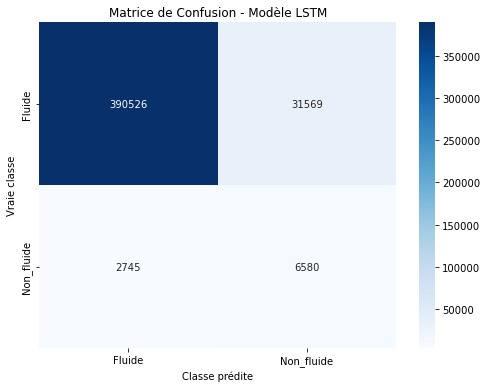

In [ ]:

# --- Prédiction et évaluation ---
print("\nÉvaluation sur le jeu de test...")
predictions_proba = model.predict(X_test)

y_pred_classes = np.argmax(predictions_proba, axis=1)

y_true_classes = np.argmax(y_test, axis=1)

target_names = ['Fluide','Non_fluide']


labels_numeriques = range(N_CLASSES) 

print("--- Rapport de Classification ---")
print(classification_report(y_true_classes, y_pred_classes, 
                            labels=labels_numeriques, 
                            target_names=target_names, 
                            zero_division=0))

# Afficher la matrice de confusion en forçant tous les labels
print("\n--- Matrice de Confusion ---")
cm = confusion_matrix(y_true_classes, y_pred_classes, labels=labels_numeriques)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice de Confusion - Modèle LSTM')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Sauvegarde des résultats

In [ ]:
max_probabilities = np.max(predictions_proba, axis=1)


In [41]:
df_resultats = df_test.iloc[N_TIMESTEPS:].copy()

In [50]:
df_resultats['code_etat_du_trafic_predit'] = y_pred_classes
df_resultats['etat_du_trafic_predit'] = df_resultats['code_etat_du_trafic_predit'].apply(lambda x  : 'Fluide' if x == 0 else 'Non-Fluide')
df_resultats['etat_du_trafic_predit_proba'] = max_probabilities
df_resultats['etat_du_trafic_reel'] = df_resultats['etat_du_trafic'].apply(lambda x  : 'Fluide' if x == 'Fluide' else 'Non-Fluide')

In [52]:
df_resultats.head()

,heure_arrondie,nom_du_troncon,taux_occupation_reel,taux_occupation,id_technique,id,debit,longueur,code_couleur,etat_du_trafic,...,has_event_near_troncon,weekday,hour,minute,troncon_enc,is_congested,code_etat_du_trafic_predit,etat_du_trafic_predit,etat_du_trafic_predit_proba,etat_du_trafic_reel
4,2025-03-08 01:00:00,3 Continents I,2.15,2.680743,nan-2025-03-08T01:00:00,nan,220.0,478.0,3.0,Fluide,...,False,5,1,0,0,0,0,Fluide,0.827036,Fluide
5,2025-03-08 01:15:00,3 Continents I,1.80,2.251380,nan-2025-03-08T01:15:00,nan,200.0,478.0,3.0,Fluide,...,False,5,1,15,0,0,0,Fluide,0.841308,Fluide
6,2025-03-08 01:30:00,3 Continents I,1.45,1.881344,nan-2025-03-08T01:30:00,nan,180.0,478.0,3.0,Fluide,...,False,5,1,30,0,0,0,Fluide,0.864902,Fluide
7,2025-03-08 01:45:00,3 Continents I,1.10,1.558817,nan-2025-03-08T01:45:00,nan,160.0,478.0,3.0,Fluide,...,False,5,1,45,0,0,0,Fluide,0.890287,Fluide
8,2025-03-08 02:00:00,3 Continents I,0.75,1.343582,nan-2025-03-08T02:00:00,nan,140.0,478.0,3.0,Fluide,...,False,5,2,0,0,0,0,Fluide,0.923939,Fluide


In [54]:
df_resultats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431420 entries, 4 to 431423
Data columns (total 63 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   heure_arrondie               431420 non-null  datetime64[ns]
 1   nom_du_troncon               431420 non-null  object        
 2   taux_occupation_reel         431420 non-null  float64       
 3   taux_occupation              431420 non-null  float64       
 4   id_technique                 431420 non-null  object        
 5   id                           431420 non-null  object        
 6   debit                        431420 non-null  float64       
 7   longueur                     431420 non-null  float64       
 8   code_couleur                 431420 non-null  float64       
 9   etat_du_trafic               431420 non-null  object        
 10  temps_de_parcours            431420 non-null  float64       
 11  vitesse                   

In [ ]:
#df_resultats.to_csv('/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/Predictions_trafic_lstm.csv', index = False)